In [1]:
##Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt 
import plotly.offline as py
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve,f1_score,recall_score,precision_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import time             

In [2]:
## For ignoring warnings to view clean output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
## Importing the dataset
data = pd.read_csv('Data/cleaned.csv',header=0)

In [7]:
### Separating Independent and Dependent features
X = data.iloc[:,:-1]
y = data.iloc[:, 14]

In [9]:
X = pd.get_dummies(X, drop_first=True)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
print("Mean of the dataset: ", np.mean(X).round(8))
print("Standard deviation of the dataset: ", np.std(X).round(8))

Mean of the dataset:  0.0
Standard deviation of the dataset:  1.0


### Data Transformation
#### Handling Categorical Variables - Creating Dummy Variables

In [ ]:
# Shows the columns with their number of categories each variable is having
for col in data.columns:
    print(col, ':', len(data[col].unique()), 'categories')

In [ ]:
pd.get_dummies(data,drop_first=True).shape

In [ ]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
X.shape

### Handling Class imbalance

In [ ]:
print('Slight Injury: ' + str(round(data['Accident_severity'].value_counts()[2] / len(data) * 100, 2)) + '%\nSerious Injury: ' + 
      str(round(data['Accident_severity'].value_counts()[1] / len(data) * 100, 2))  + '%\nFatal Injury: ' + 
      str(round(data['Accident_severity'].value_counts()[0] / len(data) * 100, 2)) + '%')

#### SMOTE Oversampling Techniques for handling imbalanced dataset

In [12]:
# Oversampling
sm = SMOTE(random_state=0)
X_over, y_over = sm.fit_sample(X, y)
## train test split
X_train_over,X_test_over,y_train_over,y_test_over = train_test_split(X_over,y_over,test_size=0.2,random_state=42)
#setting 20% aside as validation data for cross validation
x_train_t, x_train_v, y_train_t, y_train_v = train_test_split(X_train_over, y_train_over, test_size = 0.2, random_state = 42)

In [13]:
# Print class frequencies 
pd.Series(y_over).value_counts()

2    10415
1    10415
0    10415
Name: Accident_severity, dtype: int64

In [14]:
# print the shapes of our training and test set 
print(X_train_over.shape)
print(X_test_over.shape)
print(y_train_over.shape)
print(y_test_over.shape)

(24996, 99)
(6249, 99)
(24996,)
(6249,)


In [15]:
y_test_over.value_counts()

1    2100
0    2085
2    2064
Name: Accident_severity, dtype: int64

#### Random Forest Without Hyperparameter Tuning

In [16]:
start_time = time.time()
RF_model = RandomForestClassifier()
# feeding the training data into the model
RF_model.fit(X_train_over, y_train_over)
print("Execution time: " + str((time.time() - start_time)) + ' sec')

Execution time: 6.875914096832275 sec


In [17]:
# predicting the values for x-test
y_pred = RF_model.predict(X_test_over)
# finding the training and testing accuracy
name = ['Fatal','Serious','Slight']
RF_r=recall_score(y_test_over,y_pred, average='macro')
RF_p=precision_score(y_test_over,y_pred, average='macro')
RF_f=f1_score(y_test_over,y_pred, average='macro')
print("Confusion Matrix: - \n",confusion_matrix(y_test_over, y_pred))
print()
print("Classification Report: - \n",classification_report(y_test_over, y_pred,target_names=name))
print("Recall:", RF_r)
print("Precision:", RF_p)
print("F1 score:", RF_f)

Confusion Matrix: - 
 [[2056    3   26]
 [   4 1734  362]
 [   0   46 2018]]

Classification Report: - 
               precision    recall  f1-score   support

       Fatal       1.00      0.99      0.99      2085
     Serious       0.97      0.83      0.89      2100
      Slight       0.84      0.98      0.90      2064

    accuracy                           0.93      6249
   macro avg       0.94      0.93      0.93      6249
weighted avg       0.94      0.93      0.93      6249

Recall: 0.9298395303690602
Precision: 0.9364376574121245
F1 score: 0.9293569171408435


###  Random Forest with best hyperparameters

In [23]:
#Fitting the random forest model with the best hyper parameters obtained through GridSearchCV
start_time = time.time()
RF_model = RandomForestClassifier(criterion ='gini',max_depth=30,max_features='log2',min_samples_leaf=1, min_samples_split=5, n_estimators=500)
RF_model.fit(X_train_over,y_train_over)
y_pred_h = RF_model.predict(X_test_over)
print("Execution time: " + str((time.time() - start_time)) + ' sec')

Execution time: 26.050240993499756 sec


In [ ]:
## print the evaluation metrics results
name = ['Fatal','Serious','Slight']
RF_r=recall_score(y_test_over,y_pred_h, average='macro')
RF_p=precision_score(y_test_over,y_pred_h, average='macro')
RF_f=f1_score(y_test_over,y_pred_h, average='macro')
print("Confusion Matrix before PCA: - \n",confusion_matrix(y_test_over, y_pred_h))
print()
print("Classification Report before PCA: - \n",classification_report(y_test_over, y_pred_h,target_names=name))
print("F1 score before PCA:", RF_f)

### Dimension Reduction with Principal Componet Analysis (PCA)

In [25]:
pca = PCA(.95)
pca.fit(X_train_over)
Pca_test = pca.transform(X_train_over)

In [26]:
## Prints the number of Components which will have a total variance of 95%.
print(pca.n_components_)

81


In [27]:
## print explained variance
print(pca.explained_variance_)

[2.47475681 1.95700397 1.75257359 1.68767565 1.62995976 1.5677892
 1.48511101 1.45660422 1.42915482 1.36729131 1.32908128 1.28272921
 1.2440303  1.20294556 1.17667314 1.14455896 1.10881808 1.10106748
 1.09144305 1.07576066 1.0685205  1.02851694 1.02089186 1.0057415
 0.99915468 0.98257343 0.97046641 0.96738755 0.93413749 0.93090261
 0.91956959 0.91309389 0.90725059 0.89076539 0.88364338 0.86952379
 0.8587753  0.84944426 0.8353608  0.82941915 0.81948064 0.80970568
 0.80540395 0.79934868 0.78596958 0.77901415 0.76964318 0.76648797
 0.75364099 0.75075063 0.74707382 0.73793063 0.73143082 0.72162407
 0.71993234 0.70966525 0.70577369 0.69477034 0.68873675 0.66727498
 0.66563307 0.65518339 0.6515215  0.64658873 0.64234262 0.6409122
 0.62429181 0.61225435 0.60890784 0.60200329 0.59404976 0.56204634
 0.55536247 0.549481   0.52807758 0.52170687 0.51329187 0.50687754
 0.48921996 0.484781   0.47722745]


In [28]:
#shows variance ratio
print(pca.explained_variance_ratio_)

[0.03164394 0.0250236  0.02240961 0.02157978 0.02084179 0.02004683
 0.01898965 0.01862514 0.01827416 0.01748313 0.01699455 0.01640186
 0.01590703 0.01538169 0.01504575 0.01463512 0.01417811 0.01407901
 0.01395594 0.01375542 0.01366284 0.01315133 0.01305383 0.0128601
 0.01277588 0.01256386 0.01240905 0.01236968 0.01194453 0.01190316
 0.01175825 0.01167545 0.01160073 0.01138994 0.01129887 0.01111833
 0.01098089 0.01086158 0.0106815  0.01060552 0.01047844 0.01035345
 0.01029845 0.01022102 0.01004995 0.00996101 0.00984119 0.00980084
 0.00963657 0.00959961 0.0095526  0.00943569 0.00935258 0.00922718
 0.00920555 0.00907427 0.00902451 0.00888381 0.00880666 0.00853224
 0.00851124 0.00837763 0.0083308  0.00826773 0.00821343 0.00819514
 0.00798262 0.00782871 0.00778591 0.00769763 0.00759593 0.00718671
 0.00710125 0.00702604 0.00675236 0.0066709  0.0065633  0.00648129
 0.0062555  0.00619874 0.00610216]


In [29]:
## print commulative variance 
cum = pca.explained_variance_ratio_.cumsum()
print(cum)

[0.03164394 0.05666754 0.07907716 0.10065694 0.12149873 0.14154556
 0.16053521 0.17916035 0.19743451 0.21491764 0.23191219 0.24831405
 0.26422107 0.27960276 0.29464852 0.30928364 0.32346175 0.33754075
 0.3514967  0.36525211 0.37891495 0.39206628 0.4051201  0.41798021
 0.43075609 0.44331995 0.455729   0.46809868 0.48004321 0.49194637
 0.50370462 0.51538006 0.52698079 0.53837073 0.54966961 0.56078794
 0.57176883 0.58263041 0.59331191 0.60391743 0.61439587 0.62474933
 0.63504778 0.6452688  0.65531875 0.66527976 0.67512095 0.68492179
 0.69455836 0.70415798 0.71371058 0.72314626 0.73249884 0.74172602
 0.75093157 0.76000584 0.76903035 0.77791416 0.78672083 0.79525306
 0.80376431 0.81214193 0.82047273 0.82874046 0.8369539  0.84514904
 0.85313167 0.86096037 0.86874629 0.87644392 0.88403984 0.89122656
 0.8983278  0.90535384 0.91210621 0.91877711 0.92534041 0.9318217
 0.9380772  0.94427595 0.95037811]


The below dataframe shows the Cumulative Variance Ratio (how much total variance of the data is explained) and the 
Explained Variance Ratio (how much each PCA component explains the total variance of the data).

In [34]:
display(pca_df.head(10))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.031644,0.031644
1,0.056668,0.025024
2,0.079077,0.022410
3,0.100657,0.021580
4,0.121499,0.020842
5,0.141546,0.020047
6,0.160535,0.018990
7,0.179160,0.018625
8,0.197435,0.018274
9,0.214918,0.017483


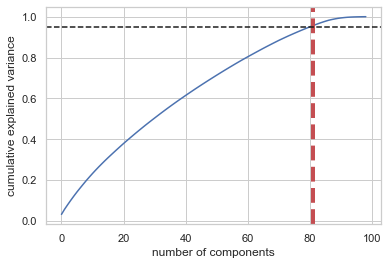

None

In [33]:
pca_test = PCA()
pca_test.fit(X_train_over)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=81, ymin=0, ymax=1)
plt.axhline(y = 0.95, color='k', linestyle='--', label = '95% Explained Variance')
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

Looking at the graph above, when we use PCA to reduce our 99 independent variables down to 81 components can still 
explain over 95% of the variance. The other 19 components explain less than 5% of the variance, so we can cut them. Using this 
logic, we will use PCA to reduce the number of components from 99 to 81.

In [35]:
pca = PCA(n_components=81)
pca.fit(X_train_over)
X_train_pca = pca.transform(X_train_over)
X_test_pca = pca.transform(X_test_over)

In [36]:
#Fitting the random forest model with the reduced number of columns
start_time = time.time()
RF_model = RandomForestClassifier(criterion ='gini',max_depth=30,max_features='log2',min_samples_leaf=1, min_samples_split=5, n_estimators=500)
RF_model.fit(X_train_pca,y_train_over)
y_pred = RF_model.predict(X_test_pca)
print("Execution time: " + str((time.time() - start_time)) + ' sec')

Execution time: 130.10434436798096 sec


In [40]:
# finding the training and testing accuracy after applying dimension reduction
name = ['Fatal','Serious','Slight']
RF_r=recall_score(y_test_over,y_pred, average='macro')
RF_p=precision_score(y_test_over,y_pred, average='macro')
RF_f=f1_score(y_test_over,y_pred, average='macro')
print("Confusion Matrix after PCA: - \n",confusion_matrix(y_test_over, y_pred))
print()
print("Classification Report after PCA: - \n",classification_report(y_test_over, y_pred,target_names=name))
print("F1 score after PCA:", RF_f)

Confusion Matrix after PCA: - 
 [[2083    0    2]
 [  14 1905  181]
 [  30  161 1873]]

Classification Report after PCA: - 
               precision    recall  f1-score   support

       Fatal       0.98      1.00      0.99      2085
     Serious       0.92      0.91      0.91      2100
      Slight       0.91      0.91      0.91      2064

    accuracy                           0.94      6249
   macro avg       0.94      0.94      0.94      6249
weighted avg       0.94      0.94      0.94      6249

F1 score after PCA: 0.9376161502651384


##### Conclusions:
From the above result we can see that afar dimensinality reduction using PCA performance of the model has increased to a certain extent against the one trained before .